In [1]:
from pymol import cmd
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from pymol import cmd, CmdException


def get_raw_distances(names='', state=1, selection='all', quiet=1):
    '''
DESCRIPTION

    Get the list of pair items from distance objects. Each list item is a
    tuple of (index1, index2, distance).

    Based on a script from Takanori Nakane, posted on pymol-users mailing list.
    http://www.mail-archive.com/pymol-users@lists.sourceforge.net/msg10143.html

ARGUMENTS

    names = string: names of distance objects (no wildcards!) {default: all
    measurement objects}

    state = integer: object state {default: 1}

    selection = string: atom selection {default: all}

SEE ALSO

    select_distances, cmd.find_pairs, cmd.get_raw_alignment
    '''
    from chempy import cpv

    state, quiet = int(state), int(quiet)
    if state < 1:
        state = cmd.get_state()

    valid_names = cmd.get_names_of_type('object:measurement')
    if names == '':
        names = ' '.join(valid_names)
    else:
        for name in names.split():
            if name not in valid_names:
                print(' Error: no such distance object: ' + name)
                raise CmdException

    raw_objects = cmd.get_session(names, 1, 1, 0, 0)['names']

    xyz2idx = {}
    cmd.iterate_state(state, selection, 'xyz2idx[x,y,z] = (model,index)',
                      space=locals())

    r = []
    for obj in raw_objects:
        try:
            points = obj[5][2][state - 1][1]
            if points is None:
                raise ValueError
        except (KeyError, ValueError, IndexError):
            continue
        for i in range(0, len(points), 6):
            xyz1 = tuple(points[i:i + 3])
            xyz2 = tuple(points[i + 3:i + 6])
            try:
                r.append((xyz2idx[xyz1], xyz2idx[xyz2], cpv.distance(xyz1, xyz2)))
                if not quiet:
                    print(' get_raw_distances: ' + str(r[-1]))
            except KeyError:
                if quiet < 0:
                    print(' Debug: no index for %s %s' % (xyz1, xyz2))
    return r

In [2]:
avaiable_DF = pd.read_csv("available_result.csv")

In [3]:
disul_A501_list = []
disul_3DAC_list = []
for i in range(avaiable_DF.shape[0]):
    cmd.load("A501/A501_summary/%s/relaxed_model_1.pdb"%avaiable_DF["A501_sequence_id"][i],"%s_1"%avaiable_DF["A501_sequence_id"][i])
    cmd.distance("disul","name SG","name SG",cutoff=2.1)
    disul_A501_list.append(len(get_raw_distances("disul")))
    cmd.reinitialize()

    cmd.load("3DAC/3DAC_summary/%s/relaxed_model_1.pdb"%avaiable_DF["3DAC_sequence_id"][i],"%s_1"%avaiable_DF["3DAC_sequence_id"][i])
    cmd.distance("disul","name SG","name SG",cutoff=2.1)
    disul_3DAC_list.append(len(get_raw_distances("disul")))
    cmd.reinitialize()

    print(i,end=",")

 PyMOL not running, entering library mode (experimental)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,2

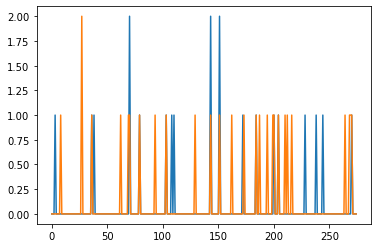

In [4]:
plt.plot(disul_A501_list)
plt.plot(disul_3DAC_list)

In [5]:
avaiable_DF["A501_disulfide_bond"] = disul_A501_list
avaiable_DF["3DAC_disulfide_bond"] = disul_3DAC_list
avaiable_DF.to_csv("available_result.csv",index=False)

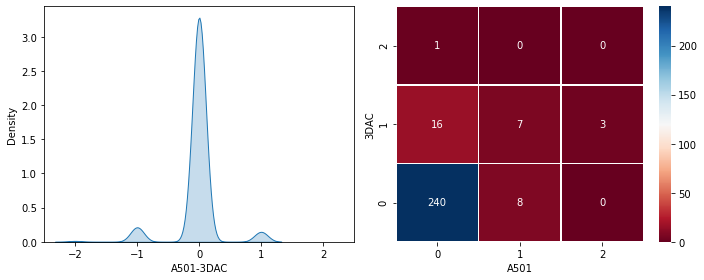

In [94]:
count_mat = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        count_mat[i,j] = sum((avaiable_DF[["A501_disulfide_bond","3DAC_disulfide_bond"]] == [i,j]).all(axis=1))

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.kdeplot(avaiable_DF["A501_disulfide_bond"]-avaiable_DF["3DAC_disulfide_bond"],shade=True)
plt.xlabel("A501-3DAC")
plt.xlim(-2.5,2.5)

plt.subplot(122)
sns.heatmap(count_mat.T,annot=True,fmt=".0f",cmap="RdBu",linewidths=.5)
plt.xlabel("A501")
plt.ylabel("3DAC")

plt.ylim(0,3)
plt.tight_layout()
plt.savefig("Figure/disulfide_bond.png",dpi=300)